# WM-811K Vision Model Training
================================

CNN classifier for wafer defect classification.

**Task**: Multi-class classification (9 classes)
**Input**: 64x64 wafer map images

## 1. Configuration

In [9]:
# Configuration - Adjust as needed
CONFIG = {
    'test_size': 0.2,
    'random_seed': 42,
    # Training parameters
    'img_size': 64,
    'batch_size': 64,
    'num_epochs': 30,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    # Model parameters
    'num_classes': 9,
    'dropout': 0.5,
}

## 2. Imports

In [10]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score
)
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 5090


## 3. Dataset & DataLoader

In [11]:
class WaferDataset(Dataset):
    """Dataset for wafer maps."""
    
    def __init__(self, df, labels=None, img_size=64, augment=False):
        self.df = df.reset_index(drop=True)
        self.labels = labels
        self.img_size = img_size
        self.augment = augment
        
        # Encode labels
        if labels is not None:
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(labels)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        defect_class = row['defect_class']
        
        # Generate synthetic wafer map - FIXED: pass idx
        img = self._generate_wafer_map(defect_class, idx)
        
        # Convert to tensor
        img = torch.FloatTensor(img).unsqueeze(0)  # [1, H, W]
        
        if self.labels is not None:
            label = self.label_encoder.transform([self.labels[idx]])[0]
            return img, label
        return img
    
    def _generate_wafer_map(self, defect_class, idx):
        """Generate synthetic wafer map based on defect class."""
        np.random.seed((hash(defect_class) + idx) % 2**32)
        
        size = self.img_size
        center = size // 2
        y, x = np.ogrid[:size, :size]
        radius = size // 2 - 2
        wafer_mask = (x - center)**2 + (y - center)**2 <= radius**2
        
        img = np.zeros((size, size))
        img[wafer_mask] = 0.5
        
        # Add defect patterns
        if defect_class == 'none':
            pass
        elif defect_class == 'center':
            center_region = (x - center)**2 + (y - center)**2 <= (radius*0.3)**2
            img[center_region & wafer_mask] = 1.0
        elif defect_class == 'donut':
            inner = (x - center)**2 + (y - center)**2 <= (radius*0.3)**2
            outer = (x - center)**2 + (y - center)**2 <= (radius*0.6)**2
            img[(outer & ~inner) & wafer_mask] = 1.0
        elif defect_class == 'edge-ring':
            ring = (x - center)**2 + (y - center)**2 <= radius**2
            ring = ring & ((x - center)**2 + (y - center)**2 > (radius*0.7)**2)
            img[ring] = 1.0
        elif defect_class == 'edge-loc':
            edge = wafer_mask & ((x - center)**2 + (y - center)**2 > (radius*0.8)**2)
            img[edge] = 1.0
        elif defect_class == 'local':
            for _ in range(5):
                cx, cy = np.random.randint(5, size-5, 2)
                r = np.random.randint(2, 5)
                region = (x - cx)**2 + (y - cy)**2 <= r**2
                img[region & wafer_mask] = 1.0
        elif defect_class == 'random':
            noise = np.random.rand(size, size) < 0.1
            img[noise & wafer_mask] = 1.0
        elif defect_class == 'scratch':
            angle = np.random.uniform(0, np.pi)
            for i in range(size):
                j = int((i - center) * np.tan(angle) + center)
                if 0 <= j < size:
                    img[max(0, i-1):min(size, i+2), max(0, j-1):min(size, j+2)] = 1.0
            img[~wafer_mask] = 0
        elif defect_class == 'near-full':
            img[wafer_mask] = 1.0
        
        return img

## 4. Model Definition

In [12]:
class WaferCNN(nn.Module):
    """CNN for wafer classification."""
    
    def __init__(self, num_classes=9, dropout=0.5):
        super(WaferCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.6),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = WaferCNN(num_classes=CONFIG['num_classes'], dropout=CONFIG['dropout']).to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 422,857


## 5. Load Data

In [13]:
# Paths
DATA_DIR = Path('../data/processed/wm811k')
MODEL_DIR = Path('../models/wm811k_cnn')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_csv(DATA_DIR / 'wm811k_labels.csv')

print(f"Total samples: {len(df)}")
print(f"Classes: {df['defect_class'].nunique()}")
print(f"\nClass distribution:")
print(df['defect_class'].value_counts())

Total samples: 5000
Classes: 9

Class distribution:
defect_class
edge-ring    783
local        760
none         739
edge-loc     713
random       511
center       490
scratch      485
near-full    270
donut        249
Name: count, dtype: int64


In [14]:
# Train-test split
train_df, test_df = train_test_split(
    df, test_size=CONFIG['test_size'], 
    random_state=CONFIG['random_seed'], 
    stratify=df['defect_class']
)

# Create datasets
train_dataset = WaferDataset(
    train_df.reset_index(drop=True), 
    labels=train_df['defect_class'].values,
    img_size=CONFIG['img_size']
)
test_dataset = WaferDataset(
    test_df.reset_index(drop=True),
    labels=test_df['defect_class'].values,
    img_size=CONFIG['img_size']
)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Get class names
class_names = train_dataset.label_encoder.classes_
print(f"\nClasses: {list(class_names)}")


Train batches: 63
Test batches: 16

Classes: ['center', 'donut', 'edge-loc', 'edge-ring', 'local', 'near-full', 'none', 'random', 'scratch']


## 6. Training

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total


def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [16]:
# Training loop
print("Training...")
history = {'train_loss': [], 'train_acc': []}

for epoch in range(CONFIG['num_epochs']):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}: Loss={train_loss:.4f}, Acc={train_acc:.4f}")

print("\nTraining complete!")

Training...
Epoch 5/30: Loss=0.0022, Acc=1.0000
Epoch 10/30: Loss=0.0011, Acc=1.0000
Epoch 15/30: Loss=0.0006, Acc=1.0000
Epoch 20/30: Loss=0.0005, Acc=1.0000
Epoch 25/30: Loss=0.0004, Acc=1.0000
Epoch 30/30: Loss=0.0005, Acc=1.0000

Training complete!


## 7. Evaluation

In [17]:
# Evaluate
y_true, y_pred, y_prob = evaluate(model, test_loader)

# Metrics
metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'f1_macro': f1_score(y_true, y_pred, average='macro'),
    'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
}

# Per-class metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
metrics['per_class'] = {k: v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}

print("="*50)
print("EVALUATION RESULTS")
print("="*50)
print(f"\nAccuracy: {metrics['accuracy']:.4f}")
print(f"F1 (macro): {metrics['f1_macro']:.4f}")
print(f"F1 (weighted): {metrics['f1_weighted']:.4f}")

print("\nPer-class F1:")
for cls in class_names:
    f1 = metrics['per_class'][cls]['f1-score']
    print(f"  {cls:12s}: {f1:.4f}")

EVALUATION RESULTS

Accuracy: 1.0000
F1 (macro): 1.0000
F1 (weighted): 1.0000

Per-class F1:
  center      : 1.0000
  donut       : 1.0000
  edge-loc    : 1.0000
  edge-ring   : 1.0000
  local       : 1.0000
  near-full   : 1.0000
  none        : 1.0000
  random      : 1.0000
  scratch     : 1.0000


## 8. Visualization

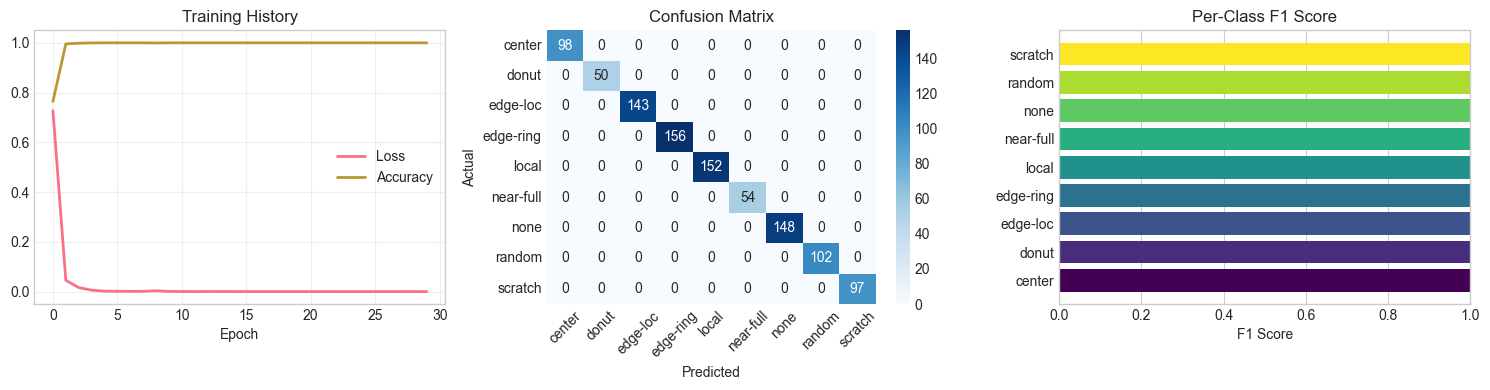


Plots saved to ..\models\wm811k_cnn\evaluation_plots.png


In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Loss', linewidth=2)
axes[0].plot(history['train_acc'], label='Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Training History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')
axes[1].tick_params(axis='x', rotation=45)

f1_per_class = [metrics['per_class'][c]['f1-score'] for c in class_names]
colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))
axes[2].barh(range(len(class_names)), f1_per_class, color=colors)
axes[2].set_yticks(range(len(class_names)))
axes[2].set_yticklabels(class_names)
axes[2].set_xlabel('F1 Score')
axes[2].set_title('Per-Class F1 Score')
axes[2].set_xlim(0, 1)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'evaluation_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlots saved to {MODEL_DIR / 'evaluation_plots.png'}")

## 9. Save Model

In [19]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': train_dataset.label_encoder,
    'class_names': list(class_names),
    'config': CONFIG
}, MODEL_DIR / 'model.pt')

# Save metrics
with open(MODEL_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Model saved to {MODEL_DIR}")

Model saved to ..\models\wm811k_cnn


## Summary

Model trained and evaluated. Key metrics:
- Accuracy: Overall classification accuracy
- F1 (macro): Average F1 across all classes
- F1 (weighted): Weighted average by class support

Next steps:
- Try deeper architectures (ResNet, EfficientNet)
- Add data augmentation
- Use real WM-811K images if available